## Data Preparation

In [1]:
import os
import pickle
from pprint import pprint
from os.path import join as JP

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

from utils.nlp_utils import preproces
from utils.general import parse_yaml, ensure_directories

from scripts.catalog import (
    Catalog, Document, Corpus,
    load_catalog, load_corpus)

config = parse_yaml('config.yaml')
paths = config['paths']
ensure_directories(paths)

In [2]:
catalog = Catalog()

## Load Catalog

In [3]:
catalog = load_catalog(path=paths['catalog'],name='spacy_pipeline_on_US_corpus')
# catalog.documents[0].sp_doc

## Load Corpus into Catalog

In [54]:
corpus = load_corpus(path=paths['catalog'], name='only_en_countries')
catalog.load_corpus(corpus=corpus)
# catalog.save(path=paths['catalog'],name='test1_clean')

'[OK] Corpus loaded into Catalog'

### Filter down the catalog

In [4]:
OF_INTEREST = ['US'] # ['CA','AU']
filters = dict(
    topic = ['isocyanate'],
    country = OF_INTEREST,
    raw_text_len = 5000)

sub_catalog = catalog.filter_catalog(filters)
sub_catalog.documents = sub_catalog.documents[:15]
print('Catalog recuded from {} to {}'.format(
    len(catalog.documents), len(sub_catalog.documents)))

Catalog recuded from 15 to 15


### SPLIT CATALOG INTO THE TWO CATEGORIES

In [5]:
filters = dict(label='relevant')
pos_catalog = sub_catalog.filter_catalog(filters)

filters = dict(label='irrelevant')
neg_catalog = sub_catalog.filter_catalog(filters)

print('Positive documents: ',len(pos_catalog.documents))
print('Negative documents: ',len(neg_catalog.documents))

Positive documents:  15
Negative documents:  0


#### Working for the Positive Labels since this is only for testing

In [6]:
catalog = pos_catalog

## Spacy

In [7]:
import spacy
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [8]:
document = catalog.documents[0]
document.clean_text[:50]

'Application published. OKAZOE, Takashi;Nagasaki, Y'

In [9]:
def spacy_cleaning(
    document,
    tags_to_keep=['JJ', 'NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
    entities_to_remove=['ORG,NORP,GPE,PERSON']):

    def pass_test(w, tags=tags_to_keep):
        if w.ent_type_ == 0:
                return w.tag_ in tags and not w.is_punct and not w.is_stop and w.ent_ not in entities_to_remove
        return w.tag_ in tags and not w.is_punct and not w.is_stop 

    words = [ word for word in document if pass_test(word)]
    tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in words ]
    return ' '.join(tokens)

#### Apply intense cleaning and save Catalog instance

In [61]:
for d,doc in enumerate(catalog.documents):
    print('[INFO]: Parsing doc ',d)
    catalog.documents[d].processed_text = spacy_cleaning(nlp(doc.clean_text))
catalog.save(path=paths['catalog'],name='spacy_pipeline_on_US_corpus')

[INFO]: Parsing doc  0
[INFO]: Parsing doc  1
[INFO]: Parsing doc  2
[INFO]: Parsing doc  3
[INFO]: Parsing doc  4
[INFO]: Parsing doc  5
[INFO]: Parsing doc  6
[INFO]: Parsing doc  7
[INFO]: Parsing doc  8
[INFO]: Parsing doc  9
[INFO]: Parsing doc  10
[INFO]: Parsing doc  11
[INFO]: Parsing doc  12
[INFO]: Parsing doc  13
[INFO]: Parsing doc  14


In [10]:
catalog.documents[0].processed_text[:50]

'application publish asahi glas method produce carb'

### Collect the Corpus for Sklearn

In [11]:
corpus = catalog.collect_corpus(attr='processed_text', form=list)
document = corpus[0]
document[:500]

'application publish asahi glas method produce carbamate compound carbamate compound method produce isocyanate compound present invention relate method produce carbamate compound comprise react fluorine contain carbonic diester compound represent formula aromatic diamine compound represent formula catalyst produce carbamate compound represent formula method produce isocyanate compound represent formula carbamate compound catalyst represent fluorine contain represent divalent divalent divalent aro'

## TFIDF

In [296]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [329]:
EMBED_SIZE = 10000        # TODO: Increase
NUM_CLUSTERS = 4
WORDS_PER_CLUSTER = 50

In [330]:
vectorizer = TfidfVectorizer(
    min_df=.1,
    max_df=.7,
    norm='l2',
    use_idf=True,
    smooth_idf=True,
    max_features=EMBED_SIZE,
    ngram_range=(1,3),
    lowercase=True,
    stop_words=stopwords.words('english'))

In [331]:
tfidf = pos_catalog.to_matrix(
    vectorizer=vectorizer,
    modelname='TFIDF',
    max_docs=None)
print(tfidf.representation.shape)
tfidf.representation.head()

(15, 9936)


,0000,0000 process,0000 process produce,0011,0015,0018,0021,0023,0028,0031,...,yield loss,yield low,yield method,yield mol,yield reaction,zeolite,zeolite diatomaceous,zeolite diatomaceous earth,zinc,zirconium
0,0.000000,0.000000,0.000000,0.0,0.005967,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.005967,0.004827,0.000000,0.000000,0.000000,0.004420,0.000000
1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.003749,0.003749,0.000000,0.003749,...,0.000000,0.000000,0.0,0.000000,0.000000,0.003033,0.000000,0.000000,0.000000,0.000000
2,0.001422,0.000474,0.000474,0.0,0.000000,0.000474,0.000474,0.000474,0.000474,0.000000,...,0.000474,0.000474,0.0,0.000000,0.000767,0.000384,0.000474,0.000474,0.000351,0.000474
3,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.007083,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [359]:
from sklearn.cluster import KMeans
def kmean_clustering(
    model, # class Model
    num_clusters:int=4, 
    words_per_cluster:int=None):
    '''
    TODO: Consider MiniBatchKMeans
    
    Clusters using k-mean with k words per cluster
    ----------------------------------------------
        The k-words are the k closest to the centroid of that cluster
        Equivalently: the words are the ones most present in the 'fake'
        document represented by the centroid of the cluster

    Inputs:
    -------
        - model: Trained instance of class Model
        - num_clusters: Number of Clusters to look for
        - words_per_cluster: K parameter above

    Returns:
    -------- 
        - Dict key='cluster id', value=k_words_closest_to_centroid
    '''
    km = KMeans(
        n_clusters=num_clusters,
        n_jobs=-1,
        random_state=43)
    
    # 1. Performs K-Means algorithm to identify clusters
    clusters=km.fit(model.representation)

    # 2. Bring K most similar words to centroid
    closests_words_to_centroids = clusters.cluster_centers_.argsort()[:, :-words_per_cluster:-1] 
    
    # 3. Create a dictionary {'cluster_id': 'important_words'}
    cluster_words = defaultdict(list)
    for i in range(num_clusters):
        for idx in closests_words_to_centroids[i, :words_per_cluster]:
            cluster_words[i].append(model.id2token[idx])
    return cluster_words

In [362]:
## CALCULATE ALL IN ONE STEPs
cluster_words = kmean_clustering(
    model=tfidf,
    num_clusters=NUM_CLUSTERS,
    words_per_cluster=5)

In [365]:
cluster_words

defaultdict(list,
            {0: ['carbamate', 'isomer', 'atom', 'include isomer'],
             1: ['mixer', 'nozzle', 'conduit', 'static'],
             2: ['aniline', 'second', 'tube', 'stream'],
             3: ['polyisocyanate', 'membrane', 'weight', 'terminate']})

## What is the importance of each word within the cluster?   
We are going to use different combinations of the TF with the IDF for each word to compute a single number.  
Note that the TF is a vector of size the number of documents.  

#### Q1: SHOULD THE TF BE REDUCED TO ONLY THOSE DOCS OF THE CLUSTER???   
 - IF NOT, TF WOULD BE n_doc LARGE VECTOR, 
 - ELSE, TF WOULD BE n_docs_in_cluster LONG VECTOR

#### CASE 0: TAKING INTO ACCOUNT ALL  
##### TAKING CLUSTER 0 AS EXAMPLE

In [263]:
"""
def _subsample_tfidf_by_cluster(tfidf,words):
    ''' Return a sample version of a TFIDF for the words of a cluster 
    NOTE: This functions implmented compute_word_importance()'''
    return tfidf[words]
"""

def get_tf_idf_of_word_from_tfidf_matrix(model,k,v):
    ''' Get the TF vector and IDF float of an specific term '''
    return model.representation[[k]].values, model.mapping.idf_[v]

def compute_word_importance(model,words_of_cluster=None):
    ''' Compute the importance of a word given the TFIDF for a bunch of
    importance methods '''
    scores = defaultdict(list)
    if not words_of_cluster: words_of_cluster = model.token2id.keys()
    for k,v in model.token2id.items():
        # With this comparison we save a lot of time
        if k in words_of_cluster:
            scores['words'].append(k)
            t,i = get_tf_idf_of_word_from_tfidf_matrix(model,k,v)
            scores['idf'].append(i)
            scores['max_tf_idf'].append(np.max(t)*i)
            scores['avg_tf_idf'].append(np.max(t)*i)
            scores['norm_tf_idf'].append(np.linalg.norm(t)*i)
    return scores

In [278]:
scores = compute_word_importance(tfidf, cluster_words[0])
pd.DataFrame(scores).head()

,words,idf,max_tf_idf,avg_tf_idf,norm_tf_idf
0,conduit,2.386294,0.995875,0.995875,1.130256
1,static,2.386294,0.980314,0.980314,1.059859
2,mixer,2.673976,1.465390,1.465390,1.743724
3,nozzle,2.386294,1.621965,1.621965,1.638386


In [227]:
def sort_scores(scores, method:str='idf'):
    err = lambda d,ds: '[ERROR]: Score method {} not among {}'.format(d,ds)
    assert method in scores.keys(), err(method, scores.keys())
    return pd.DataFrame(scores).sort_values(method,ascending=False)
sort_scores(scores).head()

,words,idf,max_tf_idf,avg_tf_idf,norm_tf_idf
2,mixer,2.673976,1.465390,1.465390,1.743724
0,conduit,2.386294,0.995875,0.995875,1.130256
1,static,2.386294,0.980314,0.980314,1.059859
3,nozzle,2.386294,1.621965,1.621965,1.638386


---

#### CASE2: SUBSAMPLING THE TF BY CLUSER
##### TAKING CLUSTER 0 AS EXAMPLE

In [93]:
tfidf_cluster_0 = tfidf.representation.loc[clusters.labels_==0, cluster_words[0]]

In [95]:
tfidf_cluster_0.head()

,mixer,nozzle,conduit,static
0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.000000
6,0.0,0.0,0.0,0.000726
7,0.0,0.0,0.0,0.000000
9,0.0,0.0,0.0,0.000000


### It looks like it doesn't make a lot of sense of subsample

---

## Plotting the WordClouds
##### Example Case: Cluster 0 with Norm_TF_IDF score

In [228]:
subsample = sort_scores(scores, 'norm_tf_idf')
subsample.head()

,words,idf,max_tf_idf,avg_tf_idf,norm_tf_idf
2,mixer,2.673976,1.465390,1.465390,1.743724
3,nozzle,2.386294,1.621965,1.621965,1.638386
0,conduit,2.386294,0.995875,0.995875,1.130256
1,static,2.386294,0.980314,0.980314,1.059859


In [244]:
from wordcloud import WordCloud
def cluster_to_wordcloud(
    df, method='idf', max_words=100, use_mask=False):
    ''' Convert 1 cluster into a WordCloud given:
        - The TFIDF for the cluster
        - The Score Method that give imporance to the word '''
    # Create the wordcloud attending to the inverse of idf
    wordcloud = WordCloud(
        max_words=max_words, 
        mask=mask_ if use_mask else None,
        background_color="white").generate_from_frequencies(
            frequencies=dict(zip(df.words, df[method])))
    return wordcloud

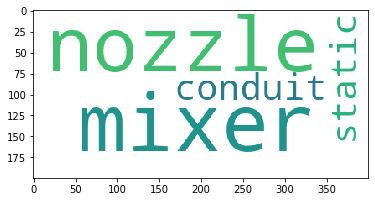

In [248]:
_, ax = plt.subplots()
wordcloud = cluster_to_wordcloud(subsample, method='idf')
ax.imshow(wordcloud)

In [294]:
def plot_clusters_as_wordclouds(
    tfidf:pd.DataFrame, 
    cluster_words:dict,
    method:str='idf',
    max_words_per_cloud=100, use_mask=False, n_cols=2):
    '''
    Arguments:
        - tfidf: TFIDF of the entire Corpus
        - cluster_words: Dict {'cluster_id': [list of important words]}
        - methods: the Score Method that give imporance to the word in that cluster
    Steps:
        - Iterate for each cluster
        - Subsample the TFIDF to the Cluster TDIDF (reduce the columns to increase performance)
        - Get the scores of the chosen methods to give importance to the words --> Not needed ???
        - Call cluster_to_wordcloud() for that cluster to get its corresponding wordcloud
    '''
    n_rows = len(cluster_words)//n_cols
    _, axs = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(n_cols*5,n_rows*5))
    
    for c,words in cluster_words.items():

        cluster_word_scores = pd.DataFrame(compute_word_importance(tfidf,words))
        # print(cluster_word_scores.head())
        wordcloud = cluster_to_wordcloud(
            df=cluster_word_scores,
            method='norm_tf_idf',
            max_words=max_words_per_cloud,
            use_mask=use_mask)
        
        # Plot the resulting wordcloud
        axs[c // n_cols, c % n_cols].imshow(wordcloud)
        axs[c // n_cols, c % n_cols].axis('off')
    plt.tight_layout()
    plt.show()
    return

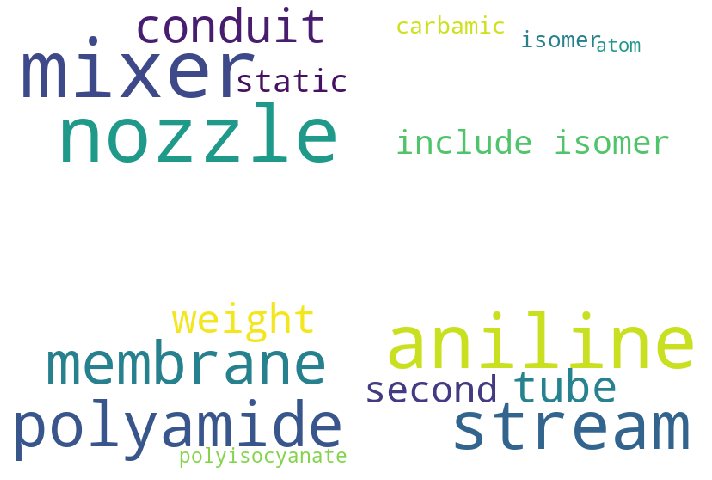

In [295]:
# cluster_words
plot_clusters_as_wordclouds(tfidf, cluster_words, method='idf')